In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [1]:
from transformers import RobertaConfig, RobertaModel, pipeline, RobertaTokenizer
import pandas as pd
import torch

In [2]:
torch.cuda.is_available()

False

In [3]:
torch.cuda.device_count()

0

In [2]:
train_set = pd.read_csv('./data/Corona_NLP_train_clean.csv')
test_set = pd.read_csv('./data/Corona_NLP_test_clean.csv')

In [3]:
# Initializing a RoBERTa configuration
configuration = RobertaConfig()

# Initializing a model from the configuration
model = RobertaModel.from_pretrained("roberta-base")

# Accessing the model configuration
configuration = model.config

In [4]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [5]:
X_train = list(train_set['OriginalTweet'].apply(lambda x: "[CLS]" + x + "[SEP]").values)

In [6]:
X_train = tokenizer(X_train)

In [7]:
X_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [8]:
len(X_train['input_ids'][0])

50

In [9]:
len(X_train['attention_mask'][0])

50

In [10]:
max_len = 0
lengths = list()
for seq in X_train['input_ids']:
    if len(seq) > max_len:
        max_len = len(seq)
    lengths.append(len(seq))

In [11]:
import matplotlib.pyplot as plt

(array([2.5210e+03, 8.6720e+03, 1.1825e+04, 1.2738e+04, 4.9370e+03,
        3.7900e+02, 3.8000e+01, 9.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([ 12. ,  25.9,  39.8,  53.7,  67.6,  81.5,  95.4, 109.3, 123.2,
        137.1, 151. ]),
 <BarContainer object of 10 artists>)

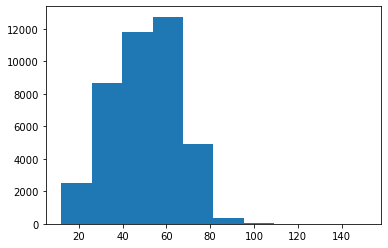

In [12]:
plt.hist(lengths)

In [13]:
max_len

151

In [14]:
def make_padded_tensor(ids, limit):
    for i, seq in enumerate(ids['input_ids']):
        if len(seq) > limit:
            ids['input_ids'][i] = seq[:limit]
            ids['attention_mask'][i] = ids['attention_mask'][i][:limit]
        else:
            ids['input_ids'][i] = seq + [0] * (limit - len(seq))
            ids['attention_mask'][i] = ids['attention_mask'][i] + [0] * (limit - len(seq))
    ids['input_ids'] = torch.LongTensor(ids['input_ids'])
    ids['attention_mask'] = torch.LongTensor(ids['attention_mask'])
    return ids

In [15]:
X_tensors = make_padded_tensor(X_train, 100)

In [16]:
X_tensors['input_ids'].shape

torch.Size([41122, 100])

In [17]:
def get_embeddings_batchwise(X_tensors, batch_size, model, embedding_size=768):
    number_of_batches = 1 + len(X_tensors['input_ids']) // batch_size
    n_examples = len(X_tensors['input_ids'])
    sequence_length = len(X_tensors['input_ids'][0])
    embeddings = torch.zeros((n_examples, sequence_length, embedding_size))
    for i in range(number_of_batches):
        print(f'batch {i} of {number_of_batches}. {i * batch_size} of {n_examples} Examples')
        results = model(X_tensors['input_ids'][i * batch_size:(i + 1) * batch_size], 
                        X_tensors['attention_mask'][i * batch_size:(i + 1) * batch_size], 
                        output_hidden_states=True) 
        hidden_dims = results[2]
        embeddings[i * batch_size:(i + 1) * batch_size] = hidden_dims[:][0]
    return embeddings

In [18]:
# stuff = model(X_tensors['input_ids'][:10], X_tensors['attention_mask'][:10], output_hidden_states=True)
embeddings = get_embeddings_batchwise(X_tensors, 128, model)

batch 0 of 322. 0 of 41122 Examples
batch 1 of 322. 128 of 41122 Examples
batch 2 of 322. 256 of 41122 Examples


KeyboardInterrupt: 

In [ ]:
#stuff = model(X_tensors['input_ids'][:10], X_tensors['attention_mask'][:10], output_hidden_states=True)

In [ ]:
stuff[2][:][0].shape

In [ ]:
len(stuff)